# Pipeline for High-z Radio Galaxies 05: AGN confusion matrix analysis

## Introduction

We want to understand how sources get to be in any quadrant of the confusion  
matrix for the prediction of AGN detection.  
In order to do that, we analyse the distribution of properties of the sources.

Training data is from HETDEX Spring Field.  
Deployment data is from Stripe 82 Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
import pandas as pd
import squarify

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

***

## Reading data

In [13]:
cat_path    = '../../Catalogs/'  # relative path to the same directory
models_path = 'models/'

We import our data using the `pandas` package.

In [14]:
save_plot_flag  = False

In [15]:
used_dataset    = 'HETDEX'  # 'HETDEX', 'S82', or 'COSMOS'
# used_dataset    = 'S82'
# used_dataset    = 'COSMOS'

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
if used_dataset == 'HETDEX':
    data_file = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)
elif used_dataset == 'S82':
    data_file = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_SDSS_DR16_5sigma_imp.h5'  # 369093 objects (3.7e5)
else:
    data_file = f'CatWISE2020_COSMOS_MILLIQUAS_{mqc_version}_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'  # 72120 objects

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'Z', 'radio_detect', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + data_file, key='df').drop(columns=features_2_discard)

In [21]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [22]:
orig_size       = len(full_catalog_df)
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [23]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {orig_size} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 6729647 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies.


---

---

## Random seed

In [24]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [25]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [26]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

#### Add columns with classes as shown by TYPE column

MQC v7.4d says:

Legend of type/class:  
     ``Q = QSO, type-I broad-line core-dominated, 792372 of these.``  
     ``A = AGN, type-I Seyferts/host-dominated, 41983 of these.``  
     ``B = BL Lac type object, 2744 of these.``  
     ``L = lensed quasar extra image, only 66 of these in this optical data.``  
     ``K = NLQSO, type-II narrow-line core-dominated, 5798 of these.``  
     ``N = NLAGN, type-II Seyferts/host-dominated, 39366 of these.  Includes an``  
                ``unquantified residue of legacy NELGs/ELGs/LINERs.``  
     ``R = radio association displayed.``  
     ``X = X-ray association displayed.``  
     ``2 = double radio lobes displayed (declared by data-driven algorithm).``  

QSO candidates (type starting with ``R/X/2``)  
Fully classified object (type starting with ``Q/A/B/K/N/L``)

In [27]:
MQC_types = ['Q', 'A', 'B', 'K', 'N', 'L', 'R', 'X', '2']
for type_val in MQC_types:
    full_catalog_df[f'is_{type_val}'] = np.array(full_catalog_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)).astype(int)

### Split data: Test, Train, Validation

In [31]:
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                   random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                   random_state=seed, stratify=train_test_df.loc[:, 'class'])

print('Shape of used data')
print('-' * 50)
print(f'Full Dataset size:                  {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Unseen Data For Validation:         {validation_df.shape}')
print('-' * 50)

Shape of used data
--------------------------------------------------
Full Dataset size:                  (85548, 51)
Data for Modeling (Train and Test): (68438, 51)
Training data:                      (47906, 51)
Testing data:                       (20532, 51)
Unseen Data For Validation:         (17110, 51)
--------------------------------------------------


In [33]:
subset_filters_df  = pd.DataFrame(data=np.array([[False] * len(full_catalog_df),\
                     [False] * len(full_catalog_df),\
                     [False] * len(full_catalog_df)]).T, columns=['train', 'test', 'validation'], index=full_catalog_df.index)
subset_filters_df.loc[test_df.index,       'train']      = True
subset_filters_df.loc[train_df.index,      'test']       = True
subset_filters_df.loc[validation_df.index, 'validation'] = True

---

## Load model(s)

In [34]:
AGN_model_01 = pyc.load_model(models_path + 'classification_AGN_galaxy_apr_20_2022')  # using only confirmed sources

Transformation Pipeline and Model Successfully Loaded


### AGN prediction

In [35]:
threshold_AGN = 0.5

In [36]:
data_pred_AGN_all = pyc.predict_model(AGN_model_01, data=full_catalog_df,\
                                        probability_threshold=threshold_AGN,\
                                        raw_score=True, round=10)

In [37]:
data_pred_AGN_train = data_pred_AGN_all.loc[train_df.index]
data_pred_AGN_test  = data_pred_AGN_all.loc[test_df.index]
data_pred_AGN_val   = data_pred_AGN_all.loc[validation_df.index]

### Create confusion matrices and scores for all individual TYPEs of sources

In [38]:
cm_mat_MQC_filts = {}
cm_mat_MQC       = {}
TN_MQC           = {}
FP_MQC           = {}
FN_MQC           = {}
TP_MQC           = {}
MCC_MQC          = {}
ACC_MQC          = {}
F1_MQC           = {}
Recall_MQC       = {}

In [40]:
for type_val in MQC_types:
    cm_mat_MQC_filts[type_val] = np.array([[(np.array(data_pred_AGN_all[f'is_{type_val}'] == 0) & np.array(data_pred_AGN_all['Label'] == 0)),\
                                            (np.array(data_pred_AGN_all[f'is_{type_val}'] == 0) & np.array(data_pred_AGN_all['Label'] == 1))],\
                                           [(np.array(data_pred_AGN_all[f'is_{type_val}'] == 1) & np.array(data_pred_AGN_all['Label'] == 0)),\
                                            (np.array(data_pred_AGN_all[f'is_{type_val}'] == 1) & np.array(data_pred_AGN_all['Label'] == 1))]])
    cm_mat_MQC[type_val]       = np.array([[np.sum(cm_mat_MQC_filts[type_val][0, 0]), np.sum(cm_mat_MQC_filts[type_val][0, 1])],\
                                           [np.sum(cm_mat_MQC_filts[type_val][1, 0]), np.sum(cm_mat_MQC_filts[type_val][1, 1])]])

    TN_MQC[type_val], FP_MQC[type_val], FN_MQC[type_val], TP_MQC[type_val] = cm_mat_MQC[type_val].flatten().astype('float32')

    MCC_MQC[type_val]          = MCC_from_CM(cm_mat_MQC[type_val])
    ACC_MQC[type_val]          = ACC_from_CM(cm_mat_MQC[type_val])
    F1_MQC[type_val]           = F1_from_CM(cm_mat_MQC[type_val])
    Recall_MQC[type_val]       = Recall_from_CM(cm_mat_MQC[type_val])

In [43]:
cm_mat_AGN_filts = np.array([[(np.array(data_pred_AGN_all['class'] == 0) & np.array(data_pred_AGN_all['Label'] == 0)),\
                              (np.array(data_pred_AGN_all['class'] == 0) & np.array(data_pred_AGN_all['Label'] == 1))],\
                             [(np.array(data_pred_AGN_all['class'] == 1) & np.array(data_pred_AGN_all['Label'] == 0)),\
                              (np.array(data_pred_AGN_all['class'] == 1) & np.array(data_pred_AGN_all['Label'] == 1))]])

In [44]:
cm_mat_AGN_all = np.array([[np.sum(cm_mat_AGN_filts[0, 0]),\
                            np.sum(cm_mat_AGN_filts[0, 1])],\
                           [np.sum(cm_mat_AGN_filts[1, 0]),\
                            np.sum(cm_mat_AGN_filts[1, 1])]])

cm_mat_AGN_train = np.array([[np.sum(cm_mat_AGN_filts[0, 0] * subset_filters_df.loc[:, 'train']),\
                              np.sum(cm_mat_AGN_filts[0, 1] * subset_filters_df.loc[:, 'train'])],\
                             [np.sum(cm_mat_AGN_filts[1, 0] * subset_filters_df.loc[:, 'train']),\
                              np.sum(cm_mat_AGN_filts[1, 1] * subset_filters_df.loc[:, 'train'])]])

cm_mat_AGN_test = np.array([[np.sum(cm_mat_AGN_filts[0, 0] * subset_filters_df.loc[:, 'test']),\
                             np.sum(cm_mat_AGN_filts[0, 1] * subset_filters_df.loc[:, 'test'])],\
                            [np.sum(cm_mat_AGN_filts[1, 0] * subset_filters_df.loc[:, 'test']),\
                             np.sum(cm_mat_AGN_filts[1, 1] * subset_filters_df.loc[:, 'test'])]])

cm_mat_AGN_val = np.array([[np.sum(cm_mat_AGN_filts[0, 0] * subset_filters_df.loc[:, 'validation']),\
                            np.sum(cm_mat_AGN_filts[0, 1] * subset_filters_df.loc[:, 'validation'])],\
                           [np.sum(cm_mat_AGN_filts[1, 0] * subset_filters_df.loc[:, 'validation']),\
                            np.sum(cm_mat_AGN_filts[1, 1] * subset_filters_df.loc[:, 'validation'])]])

In [45]:
TN_AGN_all,   FP_AGN_all,   FN_AGN_all,   TP_AGN_all   = cm_mat_AGN_all.flatten().astype('float32')
TN_AGN_train, FP_AGN_train, FN_AGN_train, TP_AGN_train = cm_mat_AGN_train.flatten().astype('float32')
TN_AGN_test,  FP_AGN_test,  FN_AGN_test,  TP_AGN_test  = cm_mat_AGN_test.flatten().astype('float32')
TN_AGN_val,   FP_AGN_val,   FN_AGN_val,   TP_AGN_val   = cm_mat_AGN_val.flatten().astype('float32')

In [56]:
MCC_AGN_all      = MCC_from_CM(cm_mat_AGN_all)
MCC_AGN_train    = MCC_from_CM(cm_mat_AGN_train)
MCC_AGN_test     = MCC_from_CM(cm_mat_AGN_test)
MCC_AGN_val      = MCC_from_CM(cm_mat_AGN_val)

ACC_AGN_all      = ACC_from_CM(cm_mat_AGN_all)
ACC_AGN_train    = ACC_from_CM(cm_mat_AGN_train)
ACC_AGN_test     = ACC_from_CM(cm_mat_AGN_test)
ACC_AGN_val      = ACC_from_CM(cm_mat_AGN_val)

F1_AGN_all       = F1_from_CM(cm_mat_AGN_all)
F1_AGN_train     = F1_from_CM(cm_mat_AGN_train)
F1_AGN_test      = F1_from_CM(cm_mat_AGN_test)
F1_AGN_val       = F1_from_CM(cm_mat_AGN_val)

Recall_AGN_all   = Recall_from_CM(cm_mat_AGN_all)
Recall_AGN_train = Recall_from_CM(cm_mat_AGN_train)
Recall_AGN_test  = Recall_from_CM(cm_mat_AGN_test)
Recall_AGN_val   = Recall_from_CM(cm_mat_AGN_val)

In [57]:
for type_val in MQC_types:
    print('-' * 50)
    print(f'Scores for MQC                     TYPE = {type_val}')
    print('Metrics for AGN detection in full dataset:')
    print(f'F1-score is                          F1 = {F1_MQC[type_val]:.4f}')
    print(f'Matthews Correlation Coefficient is MCC = {MCC_MQC[type_val]:.4f}')
    print(f'Recall is                           TPR = {Recall_MQC[type_val]:.4f}')
    print(f'Accuracy is                         ACC = {ACC_MQC[type_val]:.4f}')
    print('-' * 50  + '\n')

--------------------------------------------------
Scores for MQC                     TYPE = Q
Metrics for AGN detection in full dataset:
F1-score is                          F1 = 0.9145
Matthews Correlation Coefficient is MCC = 0.8788
Recall is                           TPR = 0.9829
Accuracy is                         ACC = 0.9449
--------------------------------------------------

--------------------------------------------------
Scores for MQC                     TYPE = A
Metrics for AGN detection in full dataset:
F1-score is                          F1 = 0.0772
Matthews Correlation Coefficient is MCC = 0.1425
Recall is                           TPR = 0.8788
Accuracy is                         ACC = 0.6675
--------------------------------------------------

--------------------------------------------------
Scores for MQC                     TYPE = B
Metrics for AGN detection in full dataset:
F1-score is                          F1 = 0.0033
Matthews Correlation Coefficient is MCC =

In [58]:
print('-' * 50)
print('Metrics for AGN detection in full dataset:')
print(f'F1-score is                          F1 = {F1_AGN_all:.4f}')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_all:.4f}')
print(f'Recall is                           TPR = {Recall_AGN_all:.4f}')
print(f'Accuracy is                         ACC = {ACC_AGN_all:.4f}')
print('-' * 50  + '\n')
print('-' * 50  + '\n')
print('Metrics for AGN detection in training sub-set:')
print(f'F1-score is                          F1 = {F1_AGN_train:.4f}')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_train:.4f}')
print(f'Recall is                           TPR = {Recall_AGN_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_AGN_train:.4f}')
print('-' * 50  + '\n')
print('-' * 50  + '\n')
print('Metrics for AGN detection in testing sub-set:')
print(f'F1-score is                          F1 = {F1_AGN_test:.4f}')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_test:.4f}')
print(f'Recall is                           TPR = {Recall_AGN_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_AGN_test:.4f}')
print('-' * 50  + '\n')
print('-' * 50  + '\n')
print('Metrics for AGN detection in validation sub-set:')
print(f'F1-score is                          F1 = {F1_AGN_val:.4f}')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_val:.4f}')
print(f'Recall is                           TPR = {Recall_AGN_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_AGN_val:.4f}')
print('-' * 50  + '\n')

--------------------------------------------------
Metrics for AGN detection in full dataset:
F1-score is                          F1 = 0.9650
Matthews Correlation Coefficient is MCC = 0.9464
Recall is                           TPR = 0.9503
Accuracy is                         ACC = 0.9755
--------------------------------------------------

--------------------------------------------------

Metrics for AGN detection in training sub-set:
F1-score is                          F1 = 0.9752
Matthews Correlation Coefficient is MCC = 0.9622
Recall is                           TPR = 0.9592
Accuracy is                         ACC = 0.9827
--------------------------------------------------

--------------------------------------------------

Metrics for AGN detection in testing sub-set:
F1-score is                          F1 = 0.9741
Matthews Correlation Coefficient is MCC = 0.9603
Recall is                           TPR = 0.9602
Accuracy is                         ACC = 0.9818
-----------------

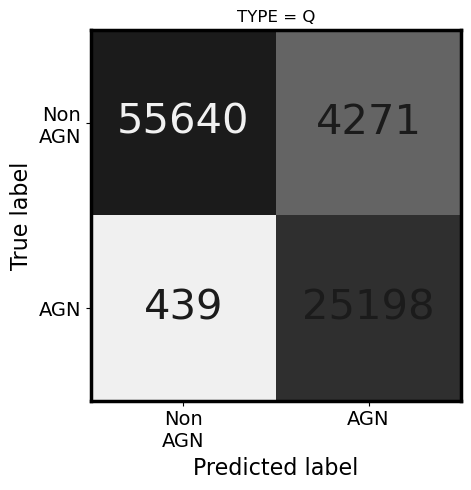

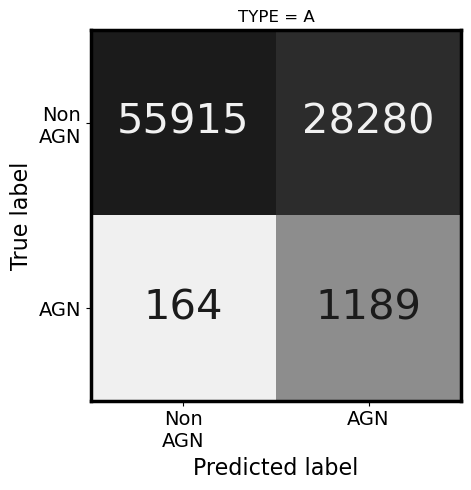

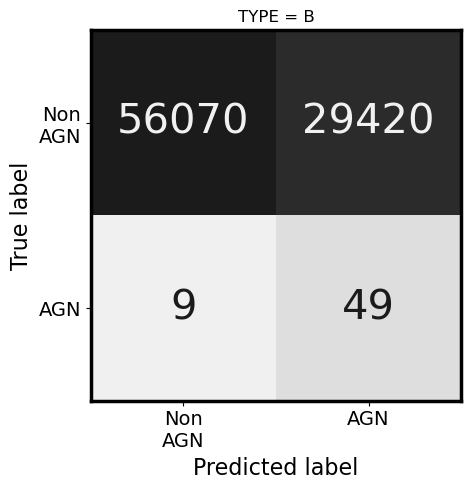

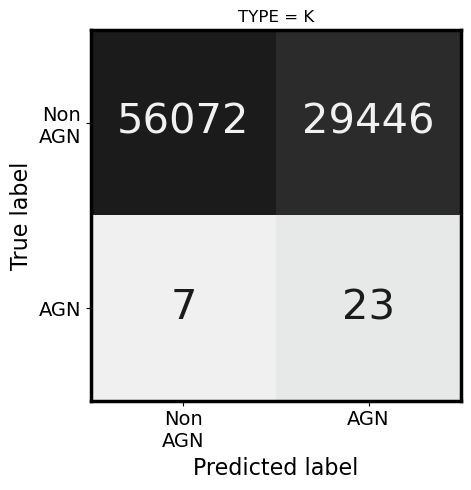

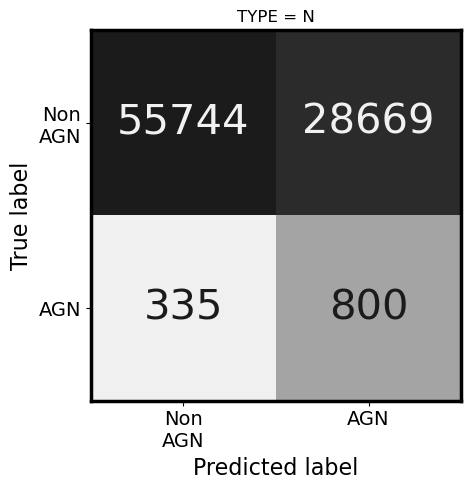

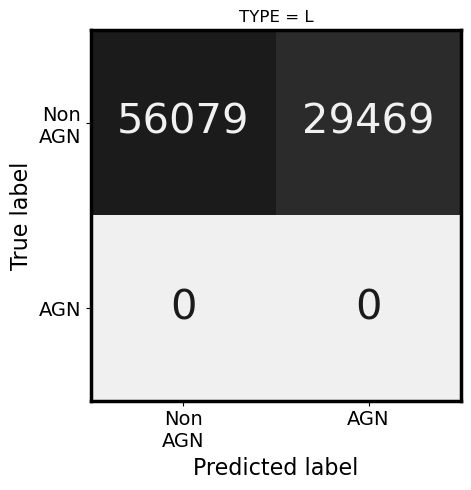

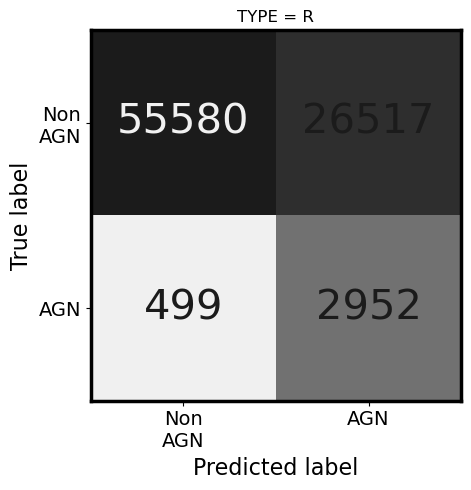

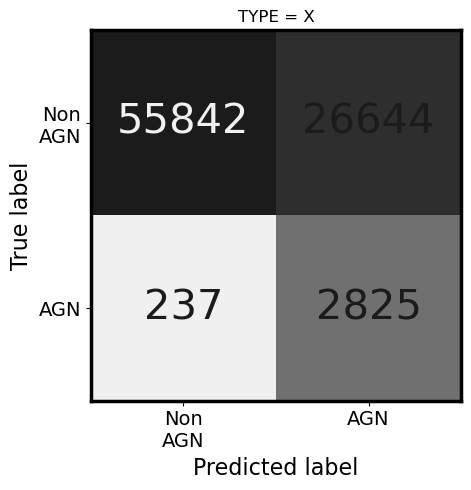

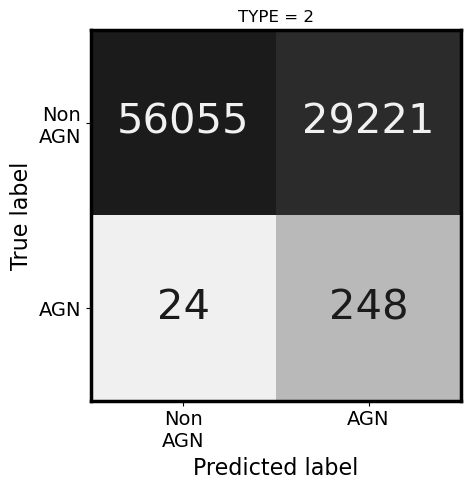

In [49]:
for type_val in MQC_types:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111)
    
    plot_conf_mat(cm_mat_MQC[type_val], title=f'TYPE = {type_val}', axin=ax1, display_labels=['Non\nAGN', 'AGN'], log_stretch=True)
    if save_plot_flag:
        plt.savefig(f'plots/confusion_matrix_AGN_{type_val}_{used_dataset}.pdf', bbox_inches='tight')
    plt.show()

### Use squarify

In [50]:
sizes_types_full   = []  # full dataset, no confusion matrix
used_types_full    = []
list_types    = ['Q', 'A', 'B', 'L', 'K', 'N']
for type_val in list_types:
    n_elems = np.sum(np.array(data_pred_AGN_all[f'is_{type_val}'] == 1))
    if n_elems == 0:
        continue
    used_types_full.append(type_val)
    sizes_types_full.append(np.sum(np.array(data_pred_AGN_all[f'is_{type_val}'] == 1)))

In [51]:
color_ll   = plt.get_cmap('cet_CET_L8', len(used_types_full))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

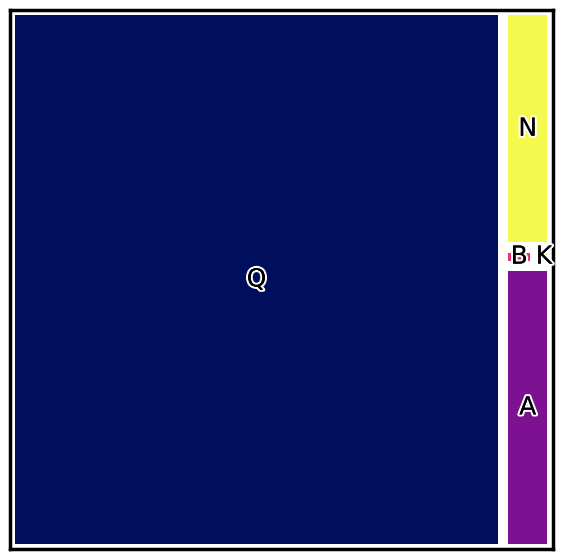

In [52]:
fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types_full, label=used_types_full, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

In [53]:
show_empty_flag = False

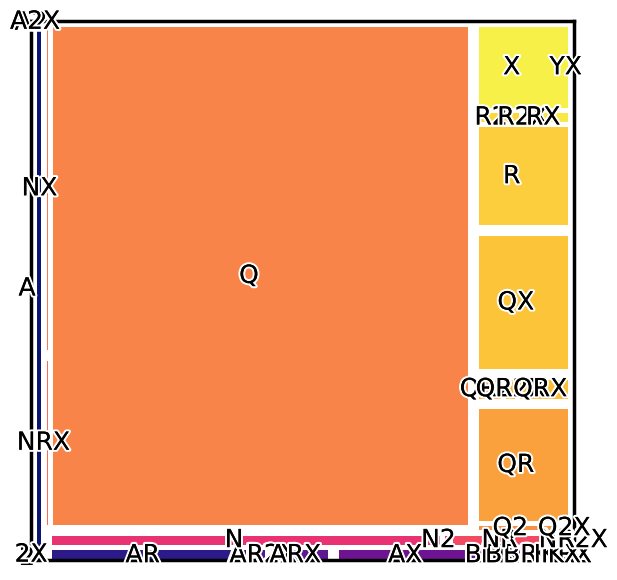

In [54]:
sizes_types   = []
list_types    = list(np.unique(data_pred_AGN_all.loc[:, 'TYPE']))
if not show_empty_flag:
    list_types.remove('    ')
for type_val in list_types:
    sizes_types.append(np.sum(data_pred_AGN_all.loc[:, 'TYPE'].str.contains(type_val, regex=False)))

color_ll   = plt.get_cmap('cet_CET_L8', len(list_types))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

if show_empty_flag:
    list_types[:] = ['0   ' if x=='    ' else x for x in list_types]

fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types, label=list_types, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

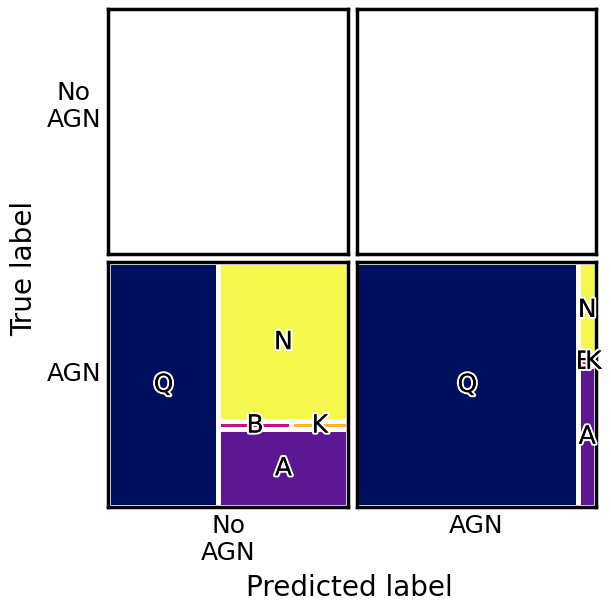

In [55]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['Q', 'A', 'B', 'L', 'K', 'N']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}


for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['Q', 'A', 'B', 'L', 'K', 'N']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(data_pred_AGN_all[f'is_{type_val}'] == 1) & cm_mat_AGN_filts[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel('No\nAGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[2].set_xlabel('No\nAGN', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='left', x=0.4)
fig.supylabel('True label', fontsize=20, va='bottom', y=0.45)
# fig.suptitle('Predicted values', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_treeplot_AGN_MQC_TYPE_{used_dataset}.pdf')
plt.show()

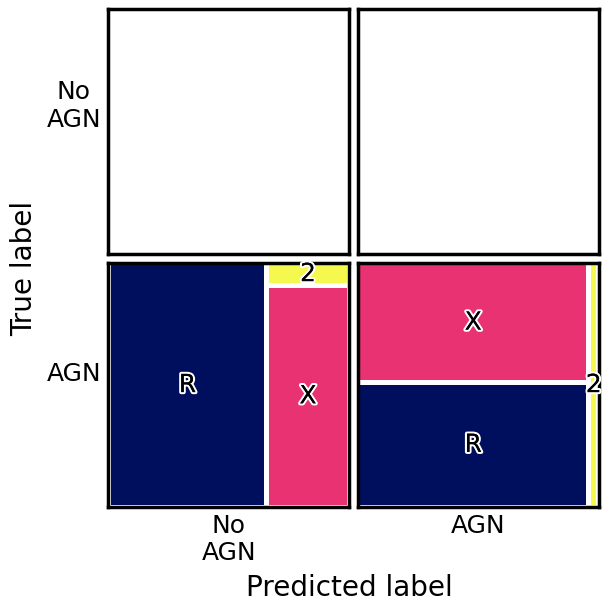

In [59]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['R', 'X', '2']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}


for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['R', 'X', '2']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(data_pred_AGN_all[f'is_{type_val}'] == 1) & cm_mat_AGN_filts[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel('No\nAGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[2].set_xlabel('No\nAGN', fontsize=18)
axs[2].set_ylabel('AGN', fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel('AGN', fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='left', x=0.4)
fig.supylabel('True label', fontsize=20, va='bottom', y=0.45)
# fig.suptitle('Predicted values', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_treeplot_AGN_MQC_TYPE_assoc_{used_dataset}.pdf')
plt.show()